In [1]:
%load_ext nb_mypy
%nb_mypy Off

Version 1.0.5


In [2]:
from __future__ import annotations
import numpy as np
import random
import copy

from typing import Tuple, List
from numpy import array, zeros

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, plot_functions, solve

## Set up Network

In [3]:
## Parameters

# task_type='Iris_classification'
task_type='Regression'
M_values: np.ndarray = array([0.15, 0.2, 0.25, 0.1, 0.02, 0.3, 0.35, 0.15, 0.03, 0.25, 0.1, 0.15, 0.02, 0.3, 0.35, 0.15, 0.03])

Nin: int = 2
Ninter: int = 0
Nout: int = 1

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec: np.ndarray = np.array([0.2])  # for allostery, regression and general_reg
# alpha_vec = np.array([0.1])  # for general_reg_allRsChange
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])
alpha: float = 0.1  # for network combine attempt

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

# R_update: str = 'R_propto_dp'
# R_update: str = 'deltaR_propto_dp'
# R_update: str = 'R_propto_Q'
R_update: str = 'deltaR_propto_Q'
R_vec_i = array([1.9, 1., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 0.9, 3., 0.85, 1.05, 0.9, 1, 0.85, 1.05, 1., 2.95, 0.55])

# training length
iterations = 440  # number of sampled of p

supress_prints: bool = False  # whether to print information during training or not
bc_noise: float = 0.0  # noise to dual problem
use_p_tag: bool = True  # use 1 or 2 sampled pressures at every time step
# use_p_tag: bool = False
# access_interNodes: bool = True  # access and change pressure at interNodes (nodes between input and output) or not
access_interNodes: bool = False  # access and change pressure at interNodes (nodes between input and output) or not
stay_sample: int = 2  # how many loop iterations to stay under the same sampled p

## Networkx sizes
scale: float = 5.0
squish: float = 0.01

In [4]:
## Variables class - mostly user choices
Variabs = User_Variables(iterations,\
                         Nin, \
                         Nout, \
                         gamma, \
                         R_update, \
                         use_p_tag, \
                         supress_prints, \
                         bc_noise, \
                         access_interNodes, \
                         task_type, \
                         M_values, \
                         Ninter)
Variabs.assign_alpha_vec(alpha)
print('alpha_vec', Variabs.alpha_vec)
Variabs.create_dataset_and_targets(M_values)

alpha_vec [0.1]
input M mismatches output and input


In [5]:
## Assign input and output nodes a.f.o lattice size and row choice
input_nodes_arr, inter_nodes_arr, output_nodes_arr, ground_nodes_arr = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs.Ninter, Variabs.Nout)

In [6]:
print('input_nodes_arr ', input_nodes_arr)
print('inter_nodes_arr ', inter_nodes_arr)
print('output_nodes_arr ', output_nodes_arr)
print('ground_nodes_arr ', ground_nodes_arr)

input_nodes_arr  [0 1]
inter_nodes_arr  []
output_nodes_arr  [2]
ground_nodes_arr  [3]


In [7]:
## Big Class containing all classes in Network Simulation
BigClass = Big_Class(Variabs)

In [8]:
## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Network_Structure(input_nodes_arr, \
                           output_nodes_arr, \
                           inter_nodes_arr, \
                           ground_nodes_arr,)
Strctr.build_incidence()
Strctr.build_edges()
BigClass.add_Strctr(Strctr)  # add to big class

In [9]:
## Initiate internal flow network state class

if access_interNodes:
    State = Network_State(Variabs.Nin, Variabs.Nout, Ninter)
else:
    State = Network_State(Variabs.Nin, Variabs.Nout)
if task_type == 'Iris_classification':
    State.initiate_resistances(BigClass, R_vec_i)
else:
    State.initiate_resistances(BigClass)
BigClass.add_State(State)  # add to big class

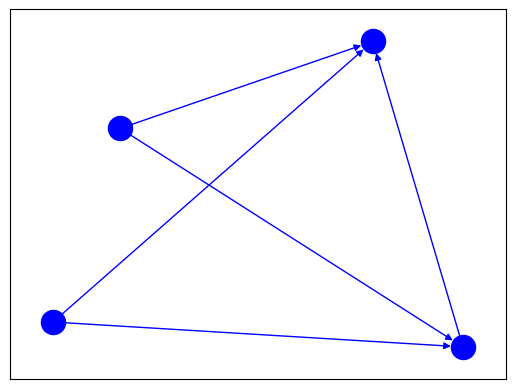

NET is ready


In [10]:
## build network graphics class and plot structure

NET = Networkx_Net(scale, squish)
NET.buildNetwork(BigClass)
NET.build_pos_lattice(BigClass, plot=True, node_labels=False)
BigClass.add_NET(NET)  # add to big class

## Train

In [11]:
for i in range(Variabs.iterations):
    print('i', i)
    # if task is classification and iteration # is beginning of epoch
    # draw output of network as output of mean of Irises
    if i % 15 == 0 and task_type == 'Iris_classification':
        targets_mat = zeros([3, 3])
        for j in range(3):
            State.draw_p_means_Iris(Variabs, j)
            # print('means[j]', State.input_drawn)
            State.solve_flow_given_problem(BigClass, "measure_for_mean")  # measure and don't change resistances
            # print('targets[j]', State.output)
            targets_mat[j] = State.output
        State.assign_targets_Iris(targets_mat)
        print(targets_mat)
    if use_p_tag:
        k = (i//stay_sample)*2 + i%2
    else:
        k = (i//stay_sample)
    print('k', k)
    State.draw_p_in_and_desired(Variabs, k)
    #print('p_drawn ', State.input_drawn)
    # print('desired output', State.desired)
    State.solve_flow_given_problem(BigClass, "measure")  # measure and don't change resistances
    # print('output meausred', State.output)
    if not i % 2 and use_p_tag:  # even iterations, take another sampled pressure and measure again
    # if not i % 2:  # even iterations, take another sampled pressure and measure again
        pass
    else:  # odd iterations, go to dual problem and update resistances
        State.calc_loss(BigClass)
        State.update_input_dual(BigClass)
        State.update_output_dual(BigClass)
        if access_interNodes:
            State.update_inter_dual(BigClass)
        State.solve_flow_given_problem(BigClass, "dual")  # measure and don't change resistances
        State.update_Rs(BigClass)

i 0
k 0
input_drawn [1.66663217 1.58269235]
desired output= [0.56653329]
output measured= [1.08310817]
i 1
k 1
input_drawn [0.72651545 1.34805629]
desired output= [0.37858858]
output measured= [0.69152391]
loss= [[-0.31293534]
 [-0.51657488]]
time= 1
input_dual_nxt= [0.01914449 0.00477812]
output_dual_nxt [-0.0079742]
i 2
k 2
input_drawn [0.48956741 0.3956763 ]
desired output= [0.15257037]
output measured= [0.29212622]
i 3
k 3
input_drawn [0.73898016 1.52087256]
desired output= [0.41502154]
output measured= [0.74811667]
loss= [[-0.33309514]
 [-0.13955585]]
time= 2
input_dual_nxt= [0.00482712 0.02177697]
output_dual_nxt [-0.00882521]
i 4
k 4
input_drawn [1.74512318 1.29181794]
desired output= [0.52013206]
output measured= [0.99278797]
i 5
k 5
input_drawn [0.40260277 0.28109682]
desired output= [0.11660978]
output measured= [0.22351189]
loss= [[-0.10690211]
 [-0.4726559 ]]
time= 3
input_dual_nxt= [0.04910319 0.03696751]
output_dual_nxt [-0.02813656]
i 6
k 6
input_drawn [0.865947   0.4644

output measured= [0.52916875]
loss= [[-0.12009835]
 [-0.19903887]]
time= 79
input_dual_nxt= [ 0.00941559 -0.00164349]
output_dual_nxt [-0.0017068]
i 158
k 158
input_drawn [1.81165977 0.60444601]
desired output= [0.39263817]
output measured= [0.55729659]
i 159
k 159
input_drawn [0.07973856 1.94849454]
desired output= [0.40165969]
output measured= [0.50643518]
loss= [[-0.10477549]
 [-0.16465842]]
time= 80
input_dual_nxt= [ 0.01037125 -0.00804856]
output_dual_nxt [-0.00030457]
i 160
k 160
input_drawn [0.9611522 0.5605862]
desired output= [0.25629007]
output measured= [0.35535852]
i 161
k 161
input_drawn [1.56257627 0.31043268]
desired output= [0.29647298]
output measured= [0.42654754]
loss= [[-0.13007456]
 [-0.09906845]]
time= 81
input_dual_nxt= [ 0.00186478 -0.00077563]
output_dual_nxt [-0.00022073]
i 162
k 162
input_drawn [1.60379949 1.82396302]
desired output= [0.60536253]
output measured= [0.81622356]
i 163
k 163
input_drawn [0.64979387 1.30413024]
desired output= [0.35829513]
output 

i 300
k 300
input_drawn [1.39286958 1.60353153]
desired output= [0.52963674]
output measured= [0.59681382]
i 301
k 301
input_drawn [0.93594008 1.18384983]
desired output= [0.37716098]
output measured= [0.42345064]
loss= [[-0.04628966]
 [-0.06717708]]
time= 151
input_dual_nxt= [0.00095441 0.00087661]
output_dual_nxt [-0.00036211]
i 302
k 302
input_drawn [0.48678752 1.89822577]
desired output= [0.45266328]
output measured= [0.49013207]
i 303
k 303
input_drawn [1.47751172 1.88844672]
desired output= [0.5993161]
output measured= [0.67196544]
loss= [[-0.07264933]
 [-0.03746879]]
time= 152
input_dual_nxt= [ 3.48542179e-03 -3.44032369e-05]
output_dual_nxt [-0.0006397]
i 304
k 304
input_drawn [1.56053588 1.818008  ]
desired output= [0.59768198]
output measured= [0.6714733]
i 305
k 305
input_drawn [0.22270902 0.0119741 ]
desired output= [0.03580117]
output measured= [0.04376811]
loss= [[-0.00796693]
 [-0.07379132]]
time= 153
input_dual_nxt= [0.00880616 0.01188811]
output_dual_nxt [-0.00413183]


## Plots

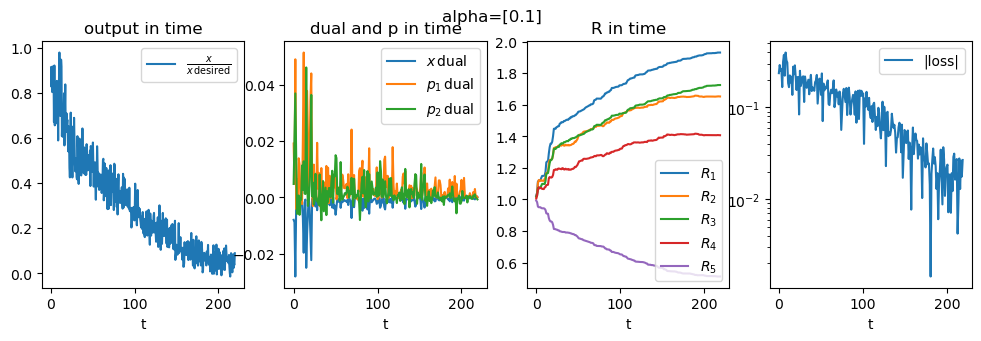

In [12]:
if hasattr(Variabs, 'M'):
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M)
else:
        plot_functions.plot_importants(State, Variabs, State.desired_in_t)

## Statistics

### Error

In [13]:
final_err = statistics.final_err(BigClass, 40)
print('final_err', final_err)

final_err 0.05253610027971068


### Accuracy

In [14]:
accuracy = zeros(np.shape(Variabs.dataset)[0])
for i, datapoint in enumerate(Variabs.dataset):
    State.draw_p_in_and_desired(Variabs, i)
    State.solve_flow_given_problem(BigClass, "measure")  # measure and don't change resistances
    accuracy[i] = statistics.calculate_accuracy(State.output, State.target_mat, Variabs.targets[i])

input_drawn [1.66663217 1.58269235]
desired output= [0.56653329]
output measured= [0.59146906]


AttributeError: 'Network_State' object has no attribute 'target_mat'

In [ ]:
Variabs.targets

In [ ]:
np.mean(accuracy)

## Checks

In [ ]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils import shuffle
from numpy.linalg import norm

In [ ]:
# Load the Iris dataset
iris = load_iris()
dataset, numerical_targets = shuffle(iris['data'], iris['target'], random_state=42)
# Min-Max Scale dataset to [0, 4]
min_max_scaler = MinMaxScaler(feature_range=(0, 4))
dataset = min_max_scaler.fit_transform(dataset)
# One-hot encode the label
encoder = OneHotEncoder(sparse_output=False, categories='auto')
targets_reshaped = numerical_targets.reshape(-1, 1)  # Reshape for the encoder
targets = encoder.fit_transform(targets_reshaped)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(np.mean(np.mean(np.abs(State.loss_in_t[1::stay_sample]), axis=1), axis=1))

In [ ]:
State.u